# Model Training - Eren Jaeger Season 2

## Import libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras.utils import register_keras_serializable

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## Preparations

In [2]:
tfk.mixed_precision.set_global_policy("mixed_bfloat16")

In [3]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [4]:
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

Running on 1 replicas
Num GPUs Available:  1
Num TPUs Available:  0


## Data Preparation

In [5]:
# Set batch size for training
BATCH_SIZE = 64
if numTPU != 0:
    BATCH_SIZE = strategy.num_replicas_in_sync * 32

print(f"Batch size: {BATCH_SIZE}")

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

Batch size: 64


In [6]:
dataset_path = '/kaggle/input/marssoil/mars_trainning_set_clean.npz'
data = np.load(dataset_path)
X = data["images"]
y = data['masks']

X = np.expand_dims(X, axis=-1)
y = np.expand_dims(y, axis=-1)

In [7]:
X.shape, y.shape

((2505, 64, 128, 1), (2505, 64, 128, 1))

In [8]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=SPLITS_SIZE, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Splitting data...
Data splitted!

Number of images:
Train: 1905
Validation: 300
Test: 300


In [9]:
# Set steps per epoch for training
STEPS_PER_EPOCH = y_train.shape[0] // BATCH_SIZE

In [10]:
# Define the category mapping
category_map = {
        0: 0,  # Background
        1: 1,  # Soil
        2: 2,  # Bedrock
        3: 3,  # Sand
        4: 4,  # Big Rock
}


# Calculate the correct number of classes after mapping
NUM_CLASSES = len(set(category_map.values()))
print(f"Number of original categories: {len(category_map)}")
print(f"Number of classes after mapping: {NUM_CLASSES}")

Number of original categories: 5
Number of classes after mapping: 5


In [11]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)

    return image, label

In [12]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [13]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [14]:
@tf.function
def apply_with_probability(augmentation_fn, image, label, prob, seed=None):
    """Applies an augmentation with a given probability."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    rand_prob = tf.random.uniform([], seed=seed)
    return tf.cond(
        rand_prob < prob,
        lambda: augmentation_fn(image, label, seed = seed),
        lambda: (image, label)
    )

@tf.function
def random_crop_resize(image, label, target_size=(64, 128), seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    print(target_size)
    # Crop the image and label independently
    image = tf.image.random_crop(image, size=[target_size[0], target_size[1], tf.shape(image)[-1]], seed=seed)
    label = tf.image.random_crop(label, size=[target_size[0], target_size[1], tf.shape(label)[-1]], seed=seed)
    
    return image, label

@tf.function
def random_brightness(image, label, delta=0.1, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    image = tf.image.stateless_random_brightness(image, max_delta=delta, seed=(seed, 0))
    return image, label

@tf.function
def random_zoom(image, label, zoom_range=(0.8, 1.2), seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    scale = tf.random.uniform([], zoom_range[0], zoom_range[1], seed=seed)
    size = tf.shape(image)[:2]
    new_size = tf.cast(size * scale, tf.int32)
    image = tf.image.resize(image, new_size)
    label = tf.image.resize(label, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.resize_with_crop_or_pad(image, size[0], size[1])
    label = tf.image.resize_with_crop_or_pad(label, size[0], size[1])
    return image, label

@tf.function
def add_gaussian_noise(image, label, stddev=0.05, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    noise = tf.random.stateless_normal(shape=tf.shape(image), mean=0.0, stddev=stddev, seed=(seed, 0), dtype=image.dtype)
    image = image + noise
    return image, label

@tf.function
def random_contrast(image, label, lower=0.8, upper=1.2, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    image = tf.image.stateless_random_contrast(image, lower, upper, seed=(seed, 0))
    return image, label

@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip with seed."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    
    def flip_fn():
        return tf.image.flip_left_right(image), tf.image.flip_left_right(label)
    
    def no_flip_fn():
        return image, label

    image, label = tf.cond(flip_prob > 0.5, flip_fn, no_flip_fn)
    return image, label

# Updated augment function to include flip
@tf.function
def fun_augment(image, label, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)
    prob = 0.5  # Default probability for all augmentations
    image, label = apply_with_probability(random_flip, image, label, prob, seed)
    image, label = apply_with_probability(random_crop_resize, image, label, prob, seed)
    image, label = apply_with_probability(random_brightness, image, label, prob, seed)
    # image, label = apply_with_probability(random_zoom, image, label, prob, seed)
    image, label = apply_with_probability(add_gaussian_noise, image, label, prob, seed)
    image, label = apply_with_probability(random_contrast, image, label, prob, seed)
    return image, label


In [15]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths)).cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        for i in range(4):
            # Apply augmentation only to a copy of the dataset
            augmented_dataset = dataset.map(
                lambda x, y: fun_augment(x, y, seed=seed),
                num_parallel_calls=tf.data.AUTOTUNE
            )
    
            # Concatenate original and augmented datasets
            dataset = dataset.concatenate(augmented_dataset)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [16]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
(64, 128)
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'int32'>


Visualizing examples from the training set:


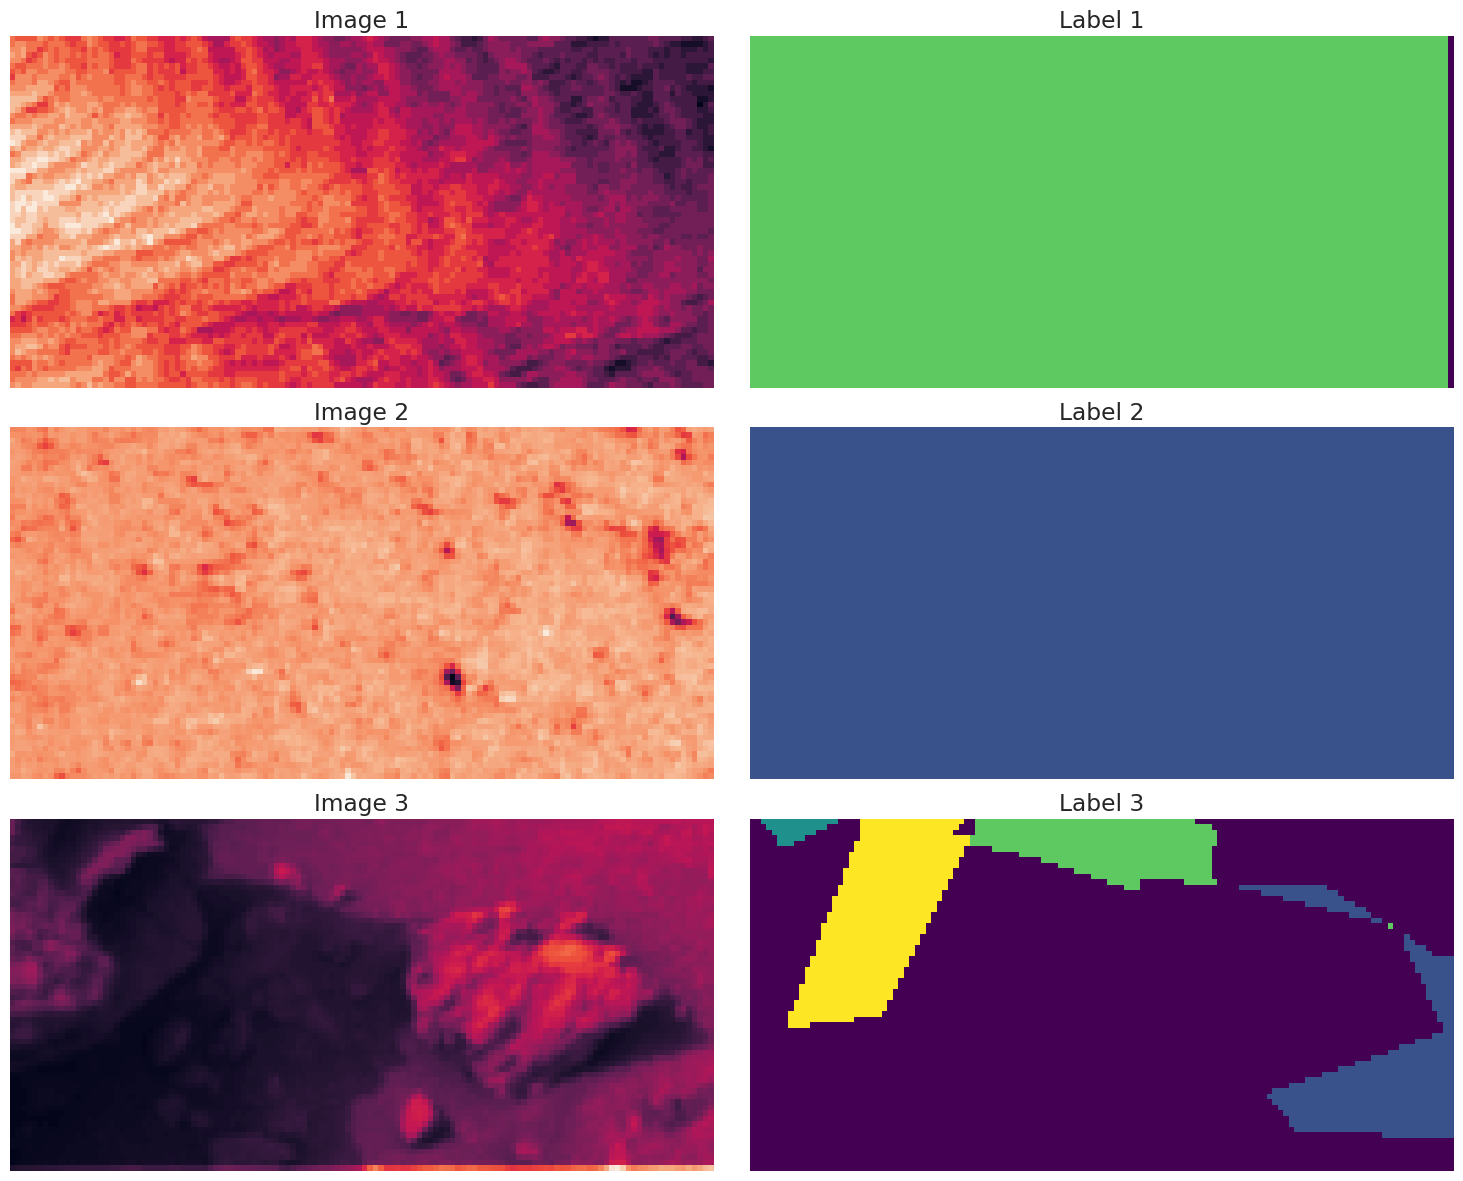

In [17]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

## Model

In [18]:
def unet_block(input_tensor, filters, kernel_size=3, activation='silu', stack=2, dropout_rate=0.0, l2_reg=0.0, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, Activation, and optional Dropout layers
    for i in range(stack):
        x = tfkl.Conv2D(
            filters, 
            kernel_size=kernel_size, 
            padding='same', 
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg), 
            name=name + 'conv' + str(i + 1)
        )(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        
        # Apply Dropout if specified
        if dropout_rate > 0:
            x = tfkl.Dropout(rate=dropout_rate, name=name + 'dropout' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [19]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed, dropout_rate=0.0, l2_reg=0.0):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, dropout_rate=dropout_rate, l2_reg=l2_reg, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, dropout_rate=dropout_rate, l2_reg=l2_reg, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)
    
    down_block_3 = unet_block(d2, 256, dropout_rate=dropout_rate, l2_reg=l2_reg, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)
    
    down_block_4 = unet_block(d3, 512, dropout_rate=dropout_rate, l2_reg=l2_reg, name='down_block4_')
    d4 = tfkl.MaxPooling2D()(down_block_4)

    # Bottleneck
    bottleneck = unet_block(d4, 1024, dropout_rate=dropout_rate, l2_reg=l2_reg, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_4])
    u1 = unet_block(u1, 512, dropout_rate=dropout_rate, l2_reg=l2_reg, name='up_block4_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_3])
    u2 = unet_block(u2, 256, dropout_rate=dropout_rate, l2_reg=l2_reg, name='up_block3_')
    
    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_2])
    u3 = unet_block(u3, 128, dropout_rate=dropout_rate, l2_reg=l2_reg, name='up_block2_')
    
    u4 = tfkl.UpSampling2D()(u3)
    u4 = tfkl.Concatenate()([u4, down_block_1])
    u4 = unet_block(u4, 64, dropout_rate=dropout_rate, l2_reg=l2_reg, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_drop… │ (None, 64, 128, │         0 │ down_block1_a… │   -   │
│ (Dropout)         │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_drop… │ (None, 64, 128, │         0 │ down_block1_a… │   -   │
│ (Dropout)         │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_d… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_drop… │ (None, 32, 64,  │         0 │ down_block2_a… │   -   │
│ (Dropout)         │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   - 

 Total params: 31,401,605 (119.79 MB)

 Trainable params: 31,389,829 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

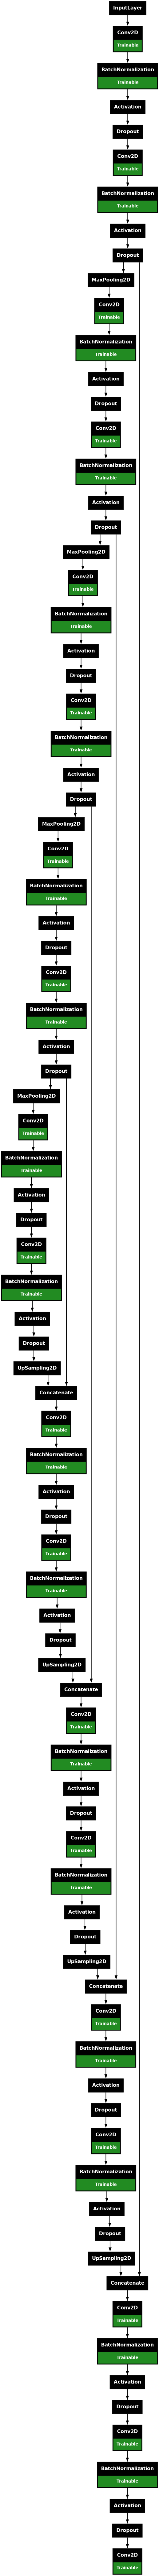

In [20]:
with strategy.scope():
    model = get_unet_model(
    input_shape=(64, 128, 1), 
    num_classes=NUM_CLASSES, 
    seed=42, 
    dropout_rate=0.1,  # 30% dropout
    l2_reg=0        # L2 regularization
    )

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [21]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [22]:
l2_lambda = 5e-4

# Compile the model
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE,  weight_decay=l2_lambda),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )
print("Model compiled!")

Compiling model...
Model compiled!


In [23]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_loss",
                                            factor=0.5,
                                            patience=30,
                                            verbose=0,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=0,
                                            min_lr=0.0,
                                        )

viz_callback = VizCallback(X_val[0], y_val[0])

Epoch 1/1000


I0000 00:00:1733065939.132745      68 service.cc:145] XLA service 0x7bace400c320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733065939.132840      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1733065945.243408      68 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1733066008.001979      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


476/477 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4891 - loss: 1.2142 - mean_iou: 0.1941

W0000 00:00:1733066113.690479      65 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.4892 - loss: 1.2139 - mean_iou: 0.1941

I0000 00:00:1733066158.659961      65 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_26', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_17', 16 bytes spill stores, 16 bytes spill loads

W0000 00:00:1733066165.055938      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733066170.891689      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


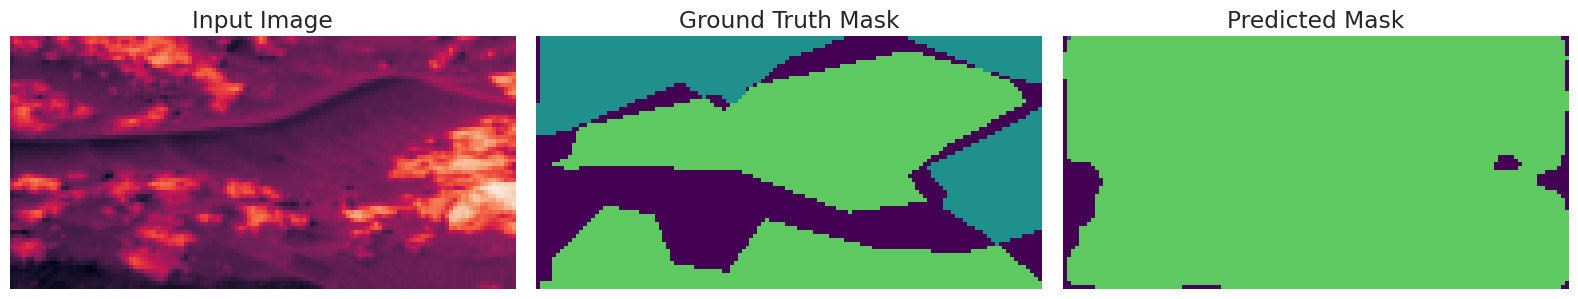

477/477 ━━━━━━━━━━━━━━━━━━━━ 261s 370ms/step - accuracy: 0.4894 - loss: 1.2136 - mean_iou: 0.1940 - val_accuracy: 0.2346 - val_loss: 2.2999 - val_mean_iou: 0.0655 - learning_rate: 0.0010
Epoch 2/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.6635 - loss: 0.8494 - mean_iou: 0.3110 - val_accuracy: 0.4516 - val_loss: 1.7468 - val_mean_iou: 0.1715 - learning_rate: 0.0010
Epoch 3/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.7016 - loss: 0.7591 - mean_iou: 0.3389 - val_accuracy: 0.6607 - val_loss: 0.8865 - val_mean_iou: 0.3474 - learning_rate: 0.0010
Epoch 4/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.7513 - loss: 0.6469 - mean_iou: 0.3789 - val_accuracy: 0.6665 - val_loss: 0.8937 - val_mean_iou: 0.3411 - learning_rate: 0.0010
Epoch 5/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.8009 - loss: 0.5239 - mean_iou: 0.4178 - val_accuracy: 0.6331 - val_loss: 1.0911 - val_mean_iou: 0.3093 - learning_rate: 0.0010
Epoch 6/1000


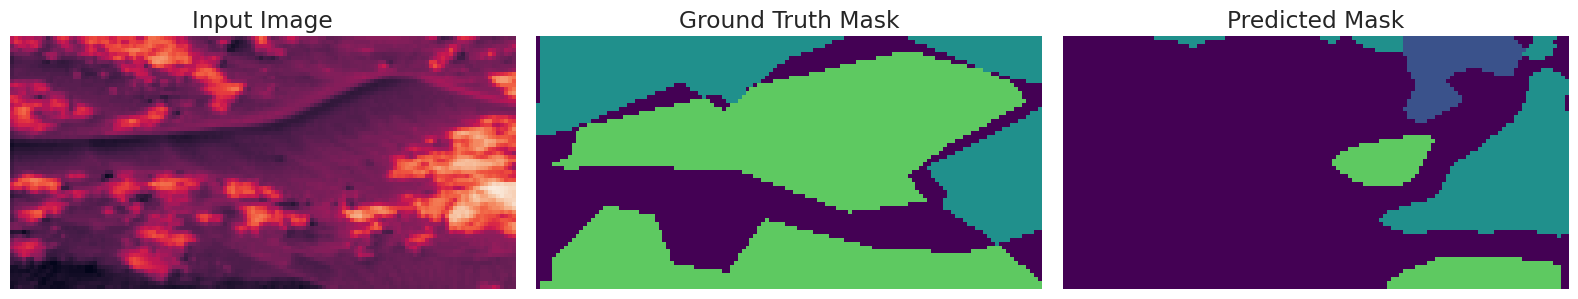

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.8442 - loss: 0.4153 - mean_iou: 0.4522 - val_accuracy: 0.6916 - val_loss: 1.1486 - val_mean_iou: 0.3756 - learning_rate: 0.0010
Epoch 7/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.8867 - loss: 0.3064 - mean_iou: 0.4878 - val_accuracy: 0.5681 - val_loss: 1.7032 - val_mean_iou: 0.2672 - learning_rate: 0.0010
Epoch 8/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9125 - loss: 0.2385 - mean_iou: 0.5191 - val_accuracy: 0.6856 - val_loss: 1.2814 - val_mean_iou: 0.3643 - learning_rate: 0.0010
Epoch 9/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9296 - loss: 0.1904 - mean_iou: 0.5984 - val_accuracy: 0.6933 - val_loss: 1.3051 - val_mean_iou: 0.3771 - learning_rate: 0.0010
Epoch 10/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9401 - loss: 0.1599 - mean_iou: 0.6516 - val_accuracy: 0.6929 - val_loss: 1.3773 - val_mean_iou: 0.3893 - learning_rate: 0.0010
Epoch 11/100

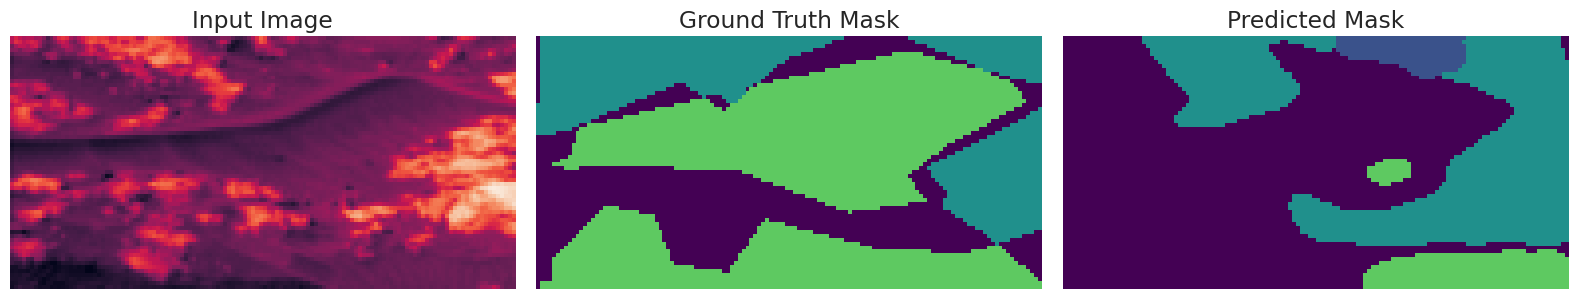

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9456 - loss: 0.1430 - mean_iou: 0.6733 - val_accuracy: 0.6784 - val_loss: 1.4658 - val_mean_iou: 0.3907 - learning_rate: 0.0010
Epoch 12/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9552 - loss: 0.1176 - mean_iou: 0.6967 - val_accuracy: 0.6720 - val_loss: 1.5422 - val_mean_iou: 0.3523 - learning_rate: 0.0010
Epoch 13/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9583 - loss: 0.1078 - mean_iou: 0.7053 - val_accuracy: 0.6843 - val_loss: 1.4561 - val_mean_iou: 0.3797 - learning_rate: 0.0010
Epoch 14/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9627 - loss: 0.0971 - mean_iou: 0.7176 - val_accuracy: 0.6975 - val_loss: 1.6533 - val_mean_iou: 0.3858 - learning_rate: 0.0010
Epoch 15/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9666 - loss: 0.0868 - mean_iou: 0.7264 - val_accuracy: 0.6304 - val_loss: 1.7459 - val_mean_iou: 0.3514 - learning_rate: 0.0010
Epoch 16/

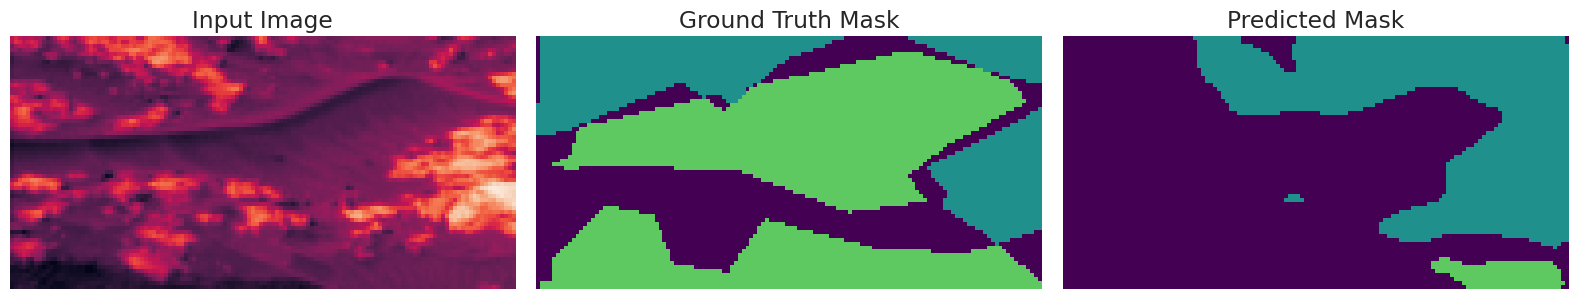

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9696 - loss: 0.0773 - mean_iou: 0.7332 - val_accuracy: 0.6700 - val_loss: 1.7765 - val_mean_iou: 0.3561 - learning_rate: 0.0010
Epoch 17/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9710 - loss: 0.0742 - mean_iou: 0.7342 - val_accuracy: 0.6466 - val_loss: 2.5137 - val_mean_iou: 0.3607 - learning_rate: 0.0010
Epoch 18/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9707 - loss: 0.0747 - mean_iou: 0.7330 - val_accuracy: 0.6528 - val_loss: 2.3216 - val_mean_iou: 0.3554 - learning_rate: 0.0010
Epoch 19/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9718 - loss: 0.0713 - mean_iou: 0.7419 - val_accuracy: 0.6672 - val_loss: 2.0964 - val_mean_iou: 0.3667 - learning_rate: 0.0010
Epoch 20/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9763 - loss: 0.0592 - mean_iou: 0.7456 - val_accuracy: 0.6888 - val_loss: 1.8852 - val_mean_iou: 0.3698 - learning_rate: 0.0010
Epoch 21/

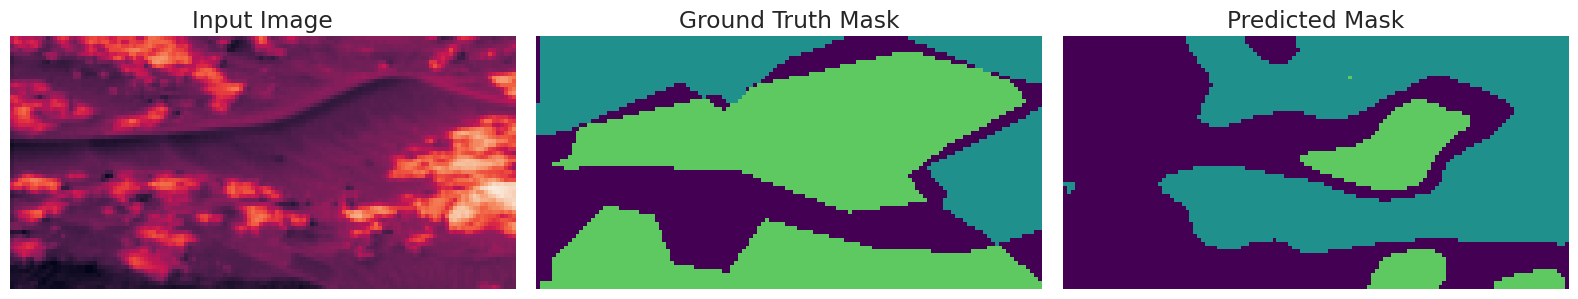

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9780 - loss: 0.0552 - mean_iou: 0.7484 - val_accuracy: 0.6502 - val_loss: 2.1468 - val_mean_iou: 0.3506 - learning_rate: 0.0010
Epoch 22/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9738 - loss: 0.0676 - mean_iou: 0.7416 - val_accuracy: 0.6950 - val_loss: 1.8314 - val_mean_iou: 0.3838 - learning_rate: 0.0010
Epoch 23/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9809 - loss: 0.0473 - mean_iou: 0.7561 - val_accuracy: 0.6790 - val_loss: 2.1872 - val_mean_iou: 0.3934 - learning_rate: 0.0010
Epoch 24/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9759 - loss: 0.0625 - mean_iou: 0.7465 - val_accuracy: 0.6966 - val_loss: 1.7606 - val_mean_iou: 0.3986 - learning_rate: 0.0010
Epoch 25/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9821 - loss: 0.0446 - mean_iou: 0.7578 - val_accuracy: 0.6467 - val_loss: 2.2336 - val_mean_iou: 0.3371 - learning_rate: 0.0010
Epoch 26/

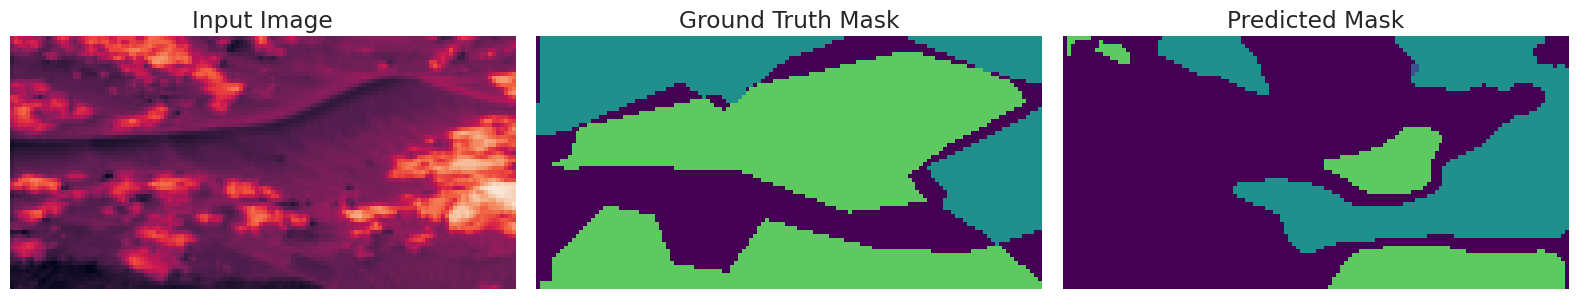

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9832 - loss: 0.0418 - mean_iou: 0.7604 - val_accuracy: 0.6674 - val_loss: 2.0270 - val_mean_iou: 0.3540 - learning_rate: 0.0010
Epoch 27/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9739 - loss: 0.0695 - mean_iou: 0.7364 - val_accuracy: 0.6842 - val_loss: 1.9953 - val_mean_iou: 0.3686 - learning_rate: 0.0010
Epoch 28/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9849 - loss: 0.0372 - mean_iou: 0.7628 - val_accuracy: 0.6498 - val_loss: 2.0575 - val_mean_iou: 0.3532 - learning_rate: 0.0010
Epoch 29/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9850 - loss: 0.0372 - mean_iou: 0.7615 - val_accuracy: 0.6722 - val_loss: 2.0666 - val_mean_iou: 0.3705 - learning_rate: 0.0010
Epoch 30/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9794 - loss: 0.0528 - mean_iou: 0.7543 - val_accuracy: 0.6657 - val_loss: 2.2360 - val_mean_iou: 0.3509 - learning_rate: 0.0010
Epoch 31/

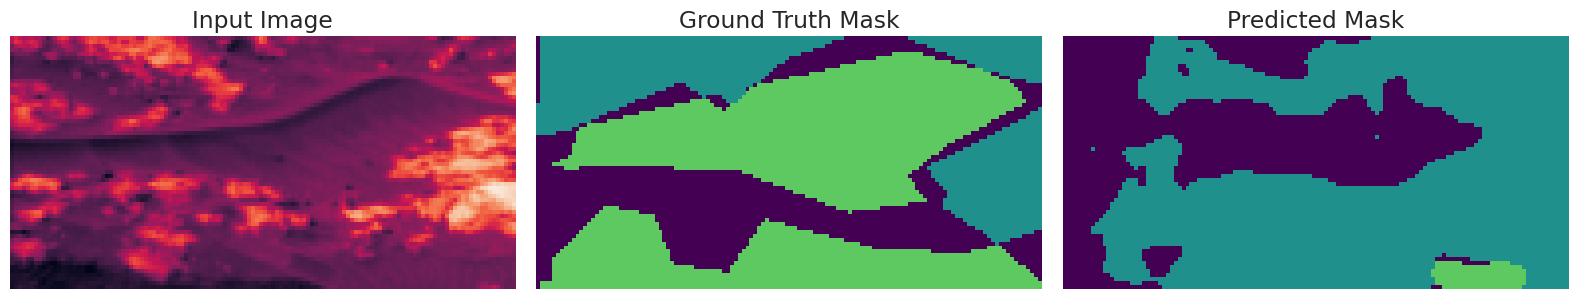

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9848 - loss: 0.0380 - mean_iou: 0.7647 - val_accuracy: 0.6717 - val_loss: 2.2306 - val_mean_iou: 0.3723 - learning_rate: 0.0010
Epoch 32/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9869 - loss: 0.0322 - mean_iou: 0.7681 - val_accuracy: 0.6570 - val_loss: 2.3646 - val_mean_iou: 0.3307 - learning_rate: 0.0010
Epoch 33/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9854 - loss: 0.0365 - mean_iou: 0.7651 - val_accuracy: 0.6523 - val_loss: 2.4043 - val_mean_iou: 0.3338 - learning_rate: 0.0010
Epoch 34/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9870 - loss: 0.0324 - mean_iou: 0.7696 - val_accuracy: 0.6957 - val_loss: 1.9071 - val_mean_iou: 0.3916 - learning_rate: 5.0000e-04
Epoch 35/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9881 - loss: 0.0297 - mean_iou: 0.7704 - val_accuracy: 0.6909 - val_loss: 2.1216 - val_mean_iou: 0.3992 - learning_rate: 5.0000e-04
E

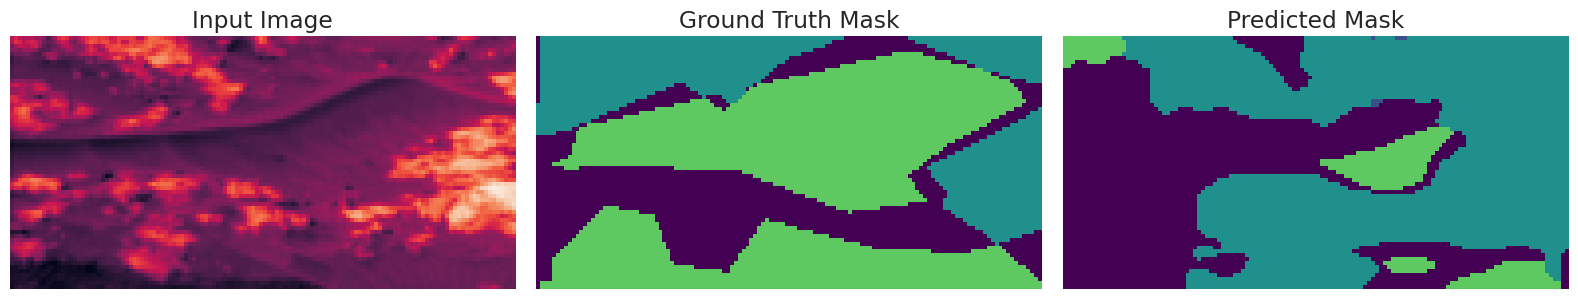

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9889 - loss: 0.0272 - mean_iou: 0.7721 - val_accuracy: 0.6993 - val_loss: 2.1054 - val_mean_iou: 0.4079 - learning_rate: 5.0000e-04
Epoch 37/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9904 - loss: 0.0231 - mean_iou: 0.7759 - val_accuracy: 0.7038 - val_loss: 2.0614 - val_mean_iou: 0.4020 - learning_rate: 5.0000e-04
Epoch 38/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9901 - loss: 0.0240 - mean_iou: 0.7741 - val_accuracy: 0.6848 - val_loss: 2.2764 - val_mean_iou: 0.3834 - learning_rate: 5.0000e-04
Epoch 39/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9908 - loss: 0.0221 - mean_iou: 0.7767 - val_accuracy: 0.6856 - val_loss: 2.2642 - val_mean_iou: 0.3777 - learning_rate: 5.0000e-04
Epoch 40/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9900 - loss: 0.0243 - mean_iou: 0.7741 - val_accuracy: 0.6839 - val_loss: 2.2356 - val_mean_iou: 0.3765 - learning_rate: 

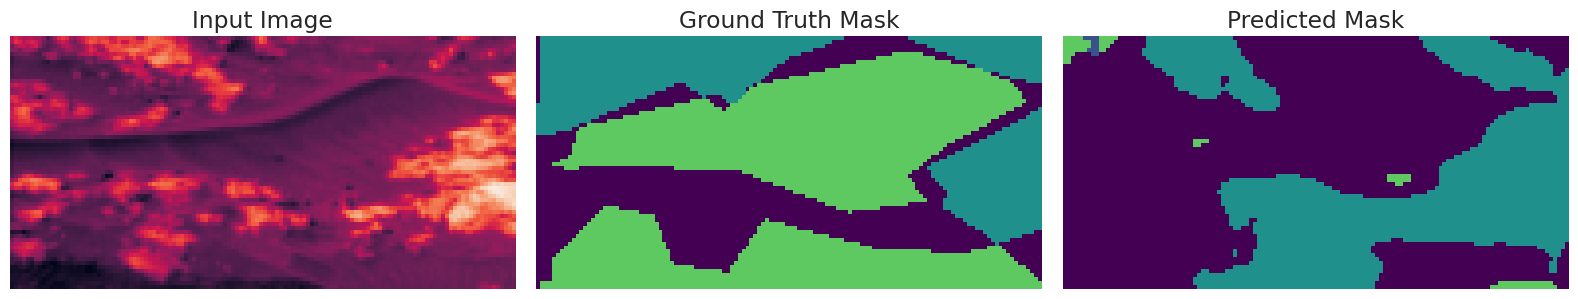

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 219ms/step - accuracy: 0.9902 - loss: 0.0238 - mean_iou: 0.7756 - val_accuracy: 0.6898 - val_loss: 2.1856 - val_mean_iou: 0.3843 - learning_rate: 5.0000e-04
Epoch 42/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9913 - loss: 0.0209 - mean_iou: 0.7778 - val_accuracy: 0.6868 - val_loss: 2.3482 - val_mean_iou: 0.3764 - learning_rate: 5.0000e-04
Epoch 43/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9916 - loss: 0.0202 - mean_iou: 0.7781 - val_accuracy: 0.6843 - val_loss: 2.2930 - val_mean_iou: 0.3735 - learning_rate: 5.0000e-04
Epoch 44/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9913 - loss: 0.0212 - mean_iou: 0.7778 - val_accuracy: 0.6768 - val_loss: 2.3698 - val_mean_iou: 0.3687 - learning_rate: 5.0000e-04
Epoch 45/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9908 - loss: 0.0225 - mean_iou: 0.7768 - val_accuracy: 0.6704 - val_loss: 2.3549 - val_mean_iou: 0.3788 - learning_rate: 

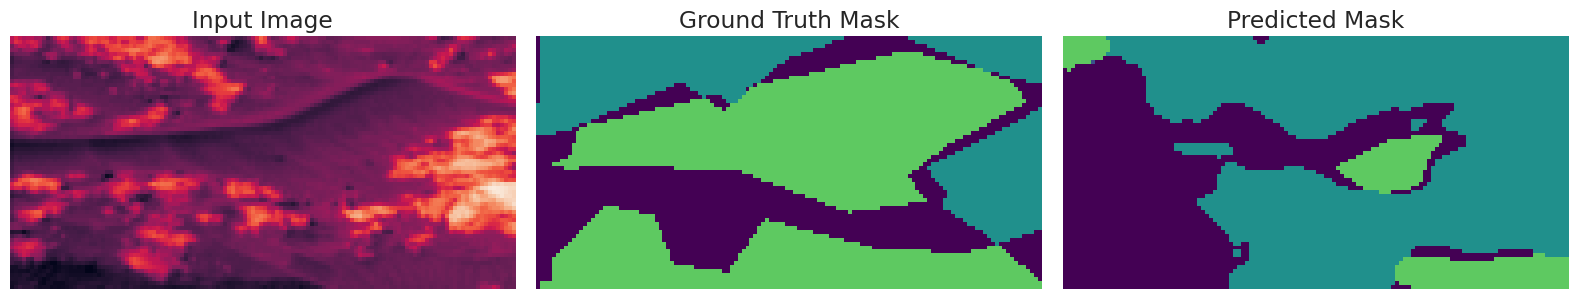

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9883 - loss: 0.0305 - mean_iou: 0.7687 - val_accuracy: 0.6766 - val_loss: 2.2075 - val_mean_iou: 0.3756 - learning_rate: 5.0000e-04
Epoch 47/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9922 - loss: 0.0188 - mean_iou: 0.7800 - val_accuracy: 0.6913 - val_loss: 2.2309 - val_mean_iou: 0.3839 - learning_rate: 5.0000e-04
Epoch 48/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9920 - loss: 0.0199 - mean_iou: 0.7784 - val_accuracy: 0.6799 - val_loss: 2.1157 - val_mean_iou: 0.3782 - learning_rate: 5.0000e-04
Epoch 49/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9920 - loss: 0.0191 - mean_iou: 0.7796 - val_accuracy: 0.6842 - val_loss: 2.1599 - val_mean_iou: 0.3812 - learning_rate: 5.0000e-04
Epoch 50/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9921 - loss: 0.0190 - mean_iou: 0.7799 - val_accuracy: 0.6877 - val_loss: 2.1206 - val_mean_iou: 0.3832 - learning_rate: 

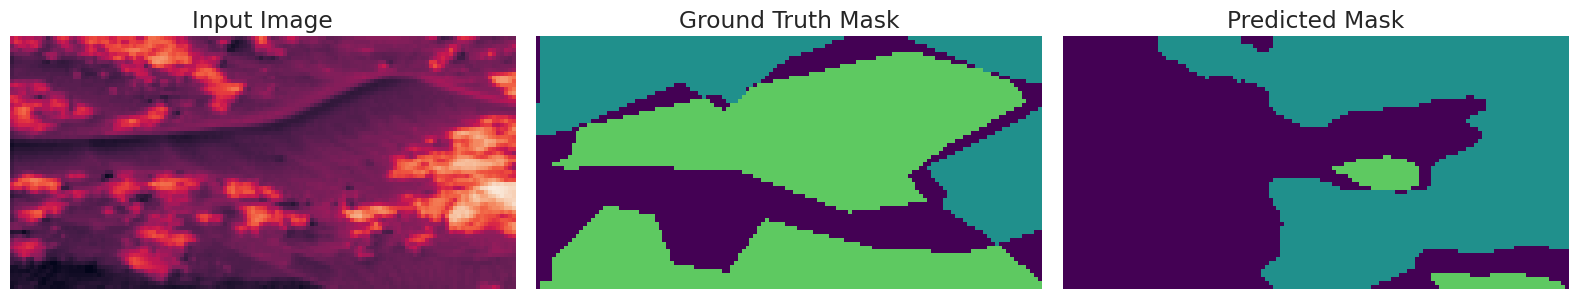

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9921 - loss: 0.0190 - mean_iou: 0.7801 - val_accuracy: 0.6548 - val_loss: 2.2860 - val_mean_iou: 0.3571 - learning_rate: 5.0000e-04
Epoch 52/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9919 - loss: 0.0198 - mean_iou: 0.7792 - val_accuracy: 0.6782 - val_loss: 2.4923 - val_mean_iou: 0.3872 - learning_rate: 5.0000e-04
Epoch 53/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9923 - loss: 0.0187 - mean_iou: 0.7805 - val_accuracy: 0.6873 - val_loss: 2.3459 - val_mean_iou: 0.3870 - learning_rate: 5.0000e-04
Epoch 54/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9921 - loss: 0.0190 - mean_iou: 0.7794 - val_accuracy: 0.6909 - val_loss: 2.5312 - val_mean_iou: 0.3929 - learning_rate: 5.0000e-04
Epoch 55/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9927 - loss: 0.0176 - mean_iou: 0.7809 - val_accuracy: 0.6788 - val_loss: 2.6352 - val_mean_iou: 0.4016 - learning_rate: 

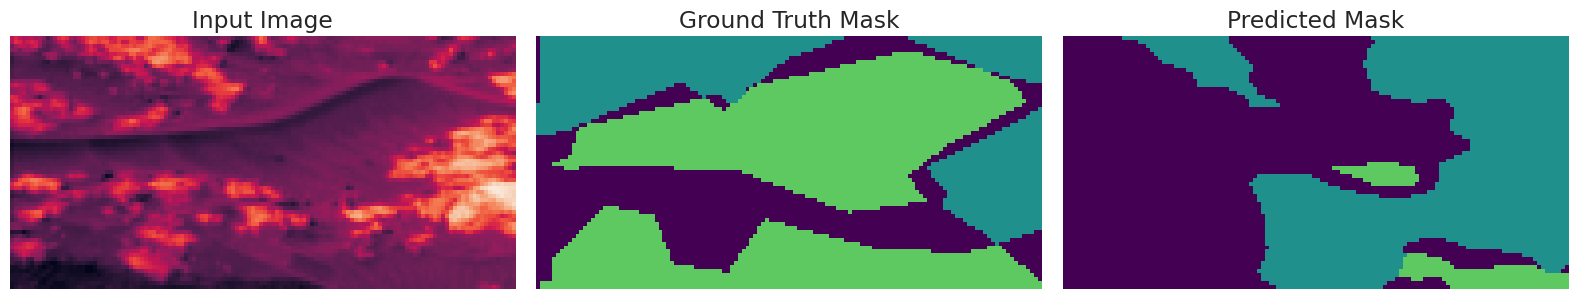

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9899 - loss: 0.0262 - mean_iou: 0.7756 - val_accuracy: 0.6843 - val_loss: 2.1689 - val_mean_iou: 0.3848 - learning_rate: 5.0000e-04
Epoch 57/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9928 - loss: 0.0174 - mean_iou: 0.7810 - val_accuracy: 0.6832 - val_loss: 2.4841 - val_mean_iou: 0.3943 - learning_rate: 5.0000e-04
Epoch 58/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9930 - loss: 0.0170 - mean_iou: 0.7814 - val_accuracy: 0.6904 - val_loss: 2.3541 - val_mean_iou: 0.3937 - learning_rate: 5.0000e-04
Epoch 59/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9935 - loss: 0.0156 - mean_iou: 0.7826 - val_accuracy: 0.6748 - val_loss: 2.4622 - val_mean_iou: 0.3715 - learning_rate: 5.0000e-04
Epoch 60/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9931 - loss: 0.0166 - mean_iou: 0.7820 - val_accuracy: 0.6484 - val_loss: 2.5111 - val_mean_iou: 0.3656 - learning_rate: 

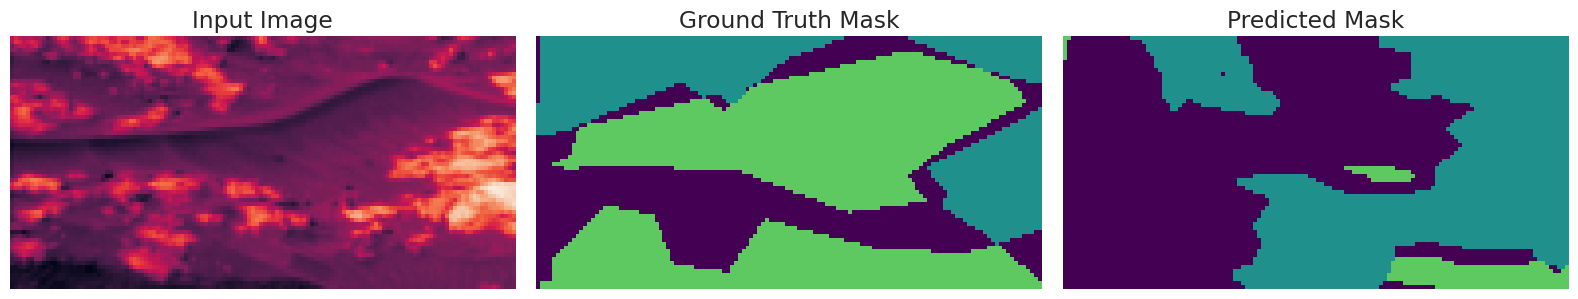

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 219ms/step - accuracy: 0.9926 - loss: 0.0183 - mean_iou: 0.7812 - val_accuracy: 0.7001 - val_loss: 2.2613 - val_mean_iou: 0.4012 - learning_rate: 5.0000e-04
Epoch 62/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9935 - loss: 0.0157 - mean_iou: 0.7830 - val_accuracy: 0.6920 - val_loss: 2.2762 - val_mean_iou: 0.4009 - learning_rate: 5.0000e-04
Epoch 63/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9932 - loss: 0.0162 - mean_iou: 0.7823 - val_accuracy: 0.6973 - val_loss: 2.4079 - val_mean_iou: 0.3958 - learning_rate: 5.0000e-04
Epoch 64/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9934 - loss: 0.0164 - mean_iou: 0.7825 - val_accuracy: 0.7093 - val_loss: 2.3129 - val_mean_iou: 0.4139 - learning_rate: 2.5000e-04
Epoch 65/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9944 - loss: 0.0134 - mean_iou: 0.7846 - val_accuracy: 0.7009 - val_loss: 2.2465 - val_mean_iou: 0.3997 - learning_rate: 

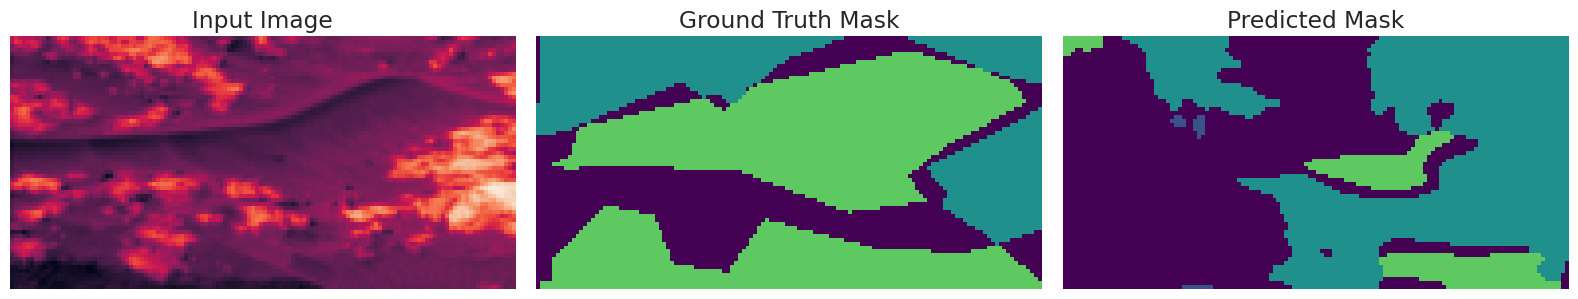

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9944 - loss: 0.0132 - mean_iou: 0.7851 - val_accuracy: 0.6982 - val_loss: 2.3491 - val_mean_iou: 0.4056 - learning_rate: 2.5000e-04
Epoch 67/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9945 - loss: 0.0131 - mean_iou: 0.7853 - val_accuracy: 0.6939 - val_loss: 2.3583 - val_mean_iou: 0.3981 - learning_rate: 2.5000e-04
Epoch 68/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9946 - loss: 0.0128 - mean_iou: 0.7856 - val_accuracy: 0.6952 - val_loss: 2.3888 - val_mean_iou: 0.3922 - learning_rate: 2.5000e-04
Epoch 69/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 219ms/step - accuracy: 0.9945 - loss: 0.0132 - mean_iou: 0.7853 - val_accuracy: 0.6932 - val_loss: 2.4176 - val_mean_iou: 0.3971 - learning_rate: 2.5000e-04
Epoch 70/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9947 - loss: 0.0126 - mean_iou: 0.7857 - val_accuracy: 0.6866 - val_loss: 2.3230 - val_mean_iou: 0.3967 - learning_rate: 

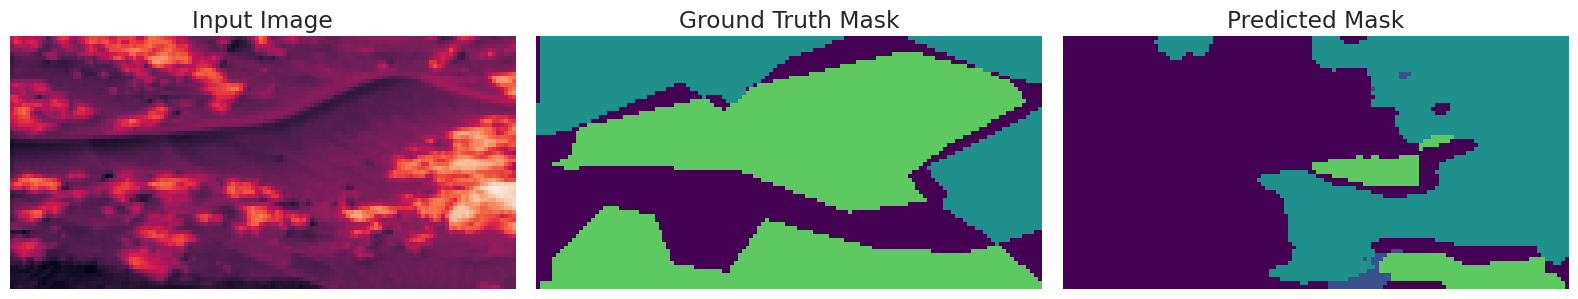

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 221ms/step - accuracy: 0.9946 - loss: 0.0128 - mean_iou: 0.7858 - val_accuracy: 0.6835 - val_loss: 2.4874 - val_mean_iou: 0.3868 - learning_rate: 2.5000e-04
Epoch 72/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9948 - loss: 0.0125 - mean_iou: 0.7859 - val_accuracy: 0.6915 - val_loss: 2.5114 - val_mean_iou: 0.3939 - learning_rate: 2.5000e-04
Epoch 73/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9949 - loss: 0.0121 - mean_iou: 0.7861 - val_accuracy: 0.6744 - val_loss: 2.6564 - val_mean_iou: 0.3820 - learning_rate: 2.5000e-04
Epoch 74/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 219ms/step - accuracy: 0.9948 - loss: 0.0125 - mean_iou: 0.7858 - val_accuracy: 0.6982 - val_loss: 2.3830 - val_mean_iou: 0.4013 - learning_rate: 2.5000e-04
Epoch 75/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9948 - loss: 0.0124 - mean_iou: 0.7857 - val_accuracy: 0.6939 - val_loss: 2.5032 - val_mean_iou: 0.3918 - learning_rate: 

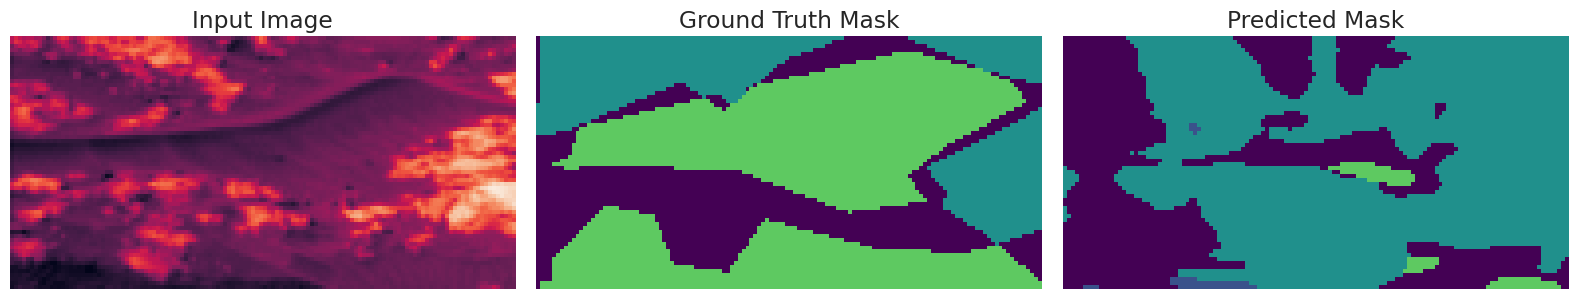

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9922 - loss: 0.0224 - mean_iou: 0.7804 - val_accuracy: 0.7001 - val_loss: 2.1468 - val_mean_iou: 0.4080 - learning_rate: 2.5000e-04
Epoch 77/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9950 - loss: 0.0120 - mean_iou: 0.7862 - val_accuracy: 0.6922 - val_loss: 2.2651 - val_mean_iou: 0.4020 - learning_rate: 2.5000e-04
Epoch 78/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9950 - loss: 0.0119 - mean_iou: 0.7869 - val_accuracy: 0.6954 - val_loss: 2.2979 - val_mean_iou: 0.4006 - learning_rate: 2.5000e-04
Epoch 79/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9951 - loss: 0.0116 - mean_iou: 0.7871 - val_accuracy: 0.6977 - val_loss: 2.3237 - val_mean_iou: 0.4024 - learning_rate: 2.5000e-04
Epoch 80/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9952 - loss: 0.0114 - mean_iou: 0.7870 - val_accuracy: 0.6881 - val_loss: 2.3240 - val_mean_iou: 0.3937 - learning_rate: 

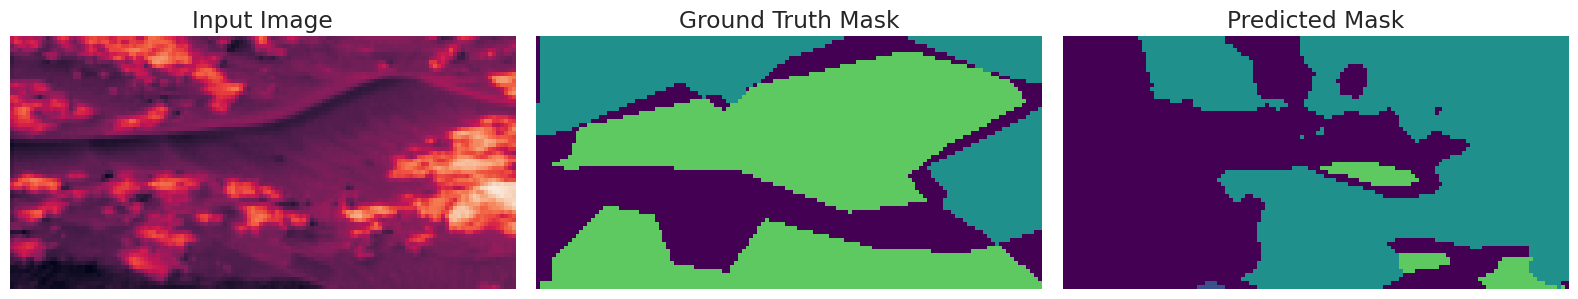

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9951 - loss: 0.0118 - mean_iou: 0.7867 - val_accuracy: 0.7020 - val_loss: 2.3270 - val_mean_iou: 0.4054 - learning_rate: 2.5000e-04
Epoch 82/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9952 - loss: 0.0115 - mean_iou: 0.7870 - val_accuracy: 0.6980 - val_loss: 2.4416 - val_mean_iou: 0.4056 - learning_rate: 2.5000e-04
Epoch 83/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9952 - loss: 0.0114 - mean_iou: 0.7870 - val_accuracy: 0.6961 - val_loss: 2.4316 - val_mean_iou: 0.3931 - learning_rate: 2.5000e-04
Epoch 84/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9952 - loss: 0.0113 - mean_iou: 0.7867 - val_accuracy: 0.6843 - val_loss: 2.6244 - val_mean_iou: 0.3871 - learning_rate: 2.5000e-04
Epoch 85/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9951 - loss: 0.0118 - mean_iou: 0.7871 - val_accuracy: 0.6983 - val_loss: 2.4475 - val_mean_iou: 0.4034 - learning_rate: 

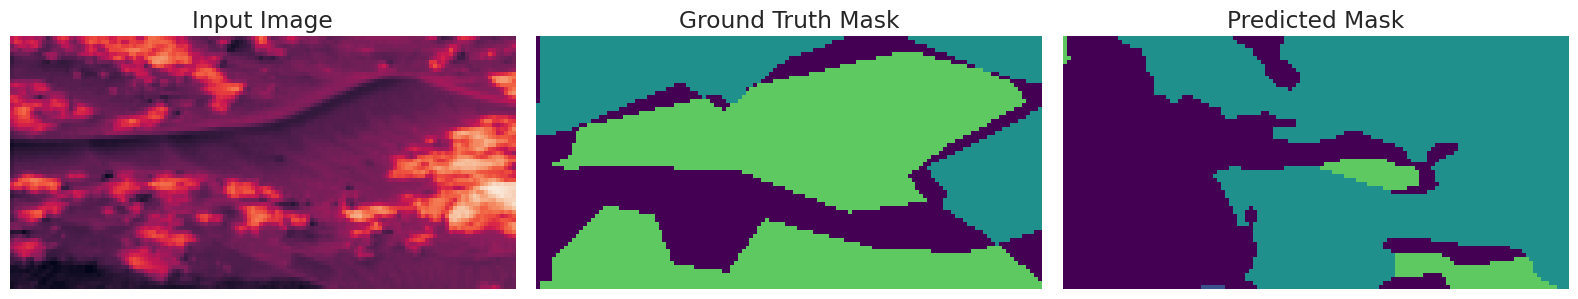

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 221ms/step - accuracy: 0.9952 - loss: 0.0114 - mean_iou: 0.7876 - val_accuracy: 0.7052 - val_loss: 2.4837 - val_mean_iou: 0.4093 - learning_rate: 2.5000e-04
Epoch 87/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9953 - loss: 0.0111 - mean_iou: 0.7878 - val_accuracy: 0.6857 - val_loss: 2.4124 - val_mean_iou: 0.3848 - learning_rate: 2.5000e-04
Epoch 88/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9952 - loss: 0.0115 - mean_iou: 0.7872 - val_accuracy: 0.6809 - val_loss: 2.5774 - val_mean_iou: 0.3859 - learning_rate: 2.5000e-04
Epoch 89/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.9953 - loss: 0.0111 - mean_iou: 0.7874 - val_accuracy: 0.6790 - val_loss: 2.4461 - val_mean_iou: 0.3836 - learning_rate: 2.5000e-04
Epoch 90/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9951 - loss: 0.0119 - mean_iou: 0.7872 - val_accuracy: 0.6892 - val_loss: 2.6475 - val_mean_iou: 0.3960 - learning_rate: 

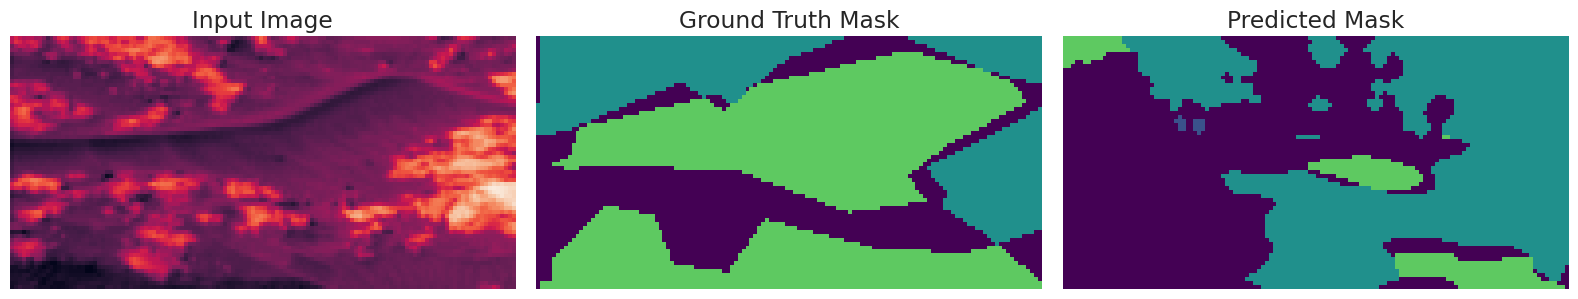

477/477 ━━━━━━━━━━━━━━━━━━━━ 105s 220ms/step - accuracy: 0.9953 - loss: 0.0111 - mean_iou: 0.7876 - val_accuracy: 0.6899 - val_loss: 2.5102 - val_mean_iou: 0.3927 - learning_rate: 2.5000e-04
Epoch 92/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9955 - loss: 0.0106 - mean_iou: 0.7878 - val_accuracy: 0.6878 - val_loss: 2.5047 - val_mean_iou: 0.3893 - learning_rate: 2.5000e-04
Epoch 93/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9956 - loss: 0.0106 - mean_iou: 0.7879 - val_accuracy: 0.6952 - val_loss: 2.4404 - val_mean_iou: 0.3855 - learning_rate: 2.5000e-04
Epoch 94/1000
477/477 ━━━━━━━━━━━━━━━━━━━━ 104s 218ms/step - accuracy: 0.9956 - loss: 0.0103 - mean_iou: 0.7885 - val_accuracy: 0.6978 - val_loss: 2.4768 - val_mean_iou: 0.4018 - learning_rate: 1.2500e-04


In [24]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    # steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[early_stopping, viz_callback, reduceLROnPlateau],
    shuffle = True,
    verbose=1
).history

In [25]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

with strategy.scope():
    # Save the trained model to a file with the accuracy included in the filename
    model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
    model.save(model_filename)

Final validation Mean Intersection Over Union: 41.39%


## Predict

In [26]:
test_path = "/kaggle/input/marssoil/mars_for_students.npz"

test_data = np.load(test_path)
X_test = test_data["test_set"]

X_test = X_test[..., np.newaxis] / 255.0

print(f"Input shape: {input_shape}")

Input shape: (64, 128, 1)


In [27]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step
Predictions shape: (10022, 64, 128)


In [28]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [29]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)